# Lab3 ResNet18
model最後兩層512,5

In [1]:
import os
import torch
print(torch.__version__)
print(torch.cuda.is_available())
device=torch.device('cuda',1)
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models
import torch.nn as nn
import torch.optim as optim
import copy
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

1.4.0
True


## DataSet & DataLoader
data augmentation:  
1. RandomHorizontalFlip
2. RandomVerticalFilp
3. Normalize each channel(R,G,B)

In [2]:
class RetinopathyDataSet(Dataset):
    def __init__(self, img_path, mode):
        """
        Args:
            img_path: Root path of the dataset.
            mode: training/testing
            
            self.img_names (string list): String list that store all image names.
            self.labels (int or float list): Numerical list that store all ground truth label values.
        """
        self.img_path = img_path
        self.mode = mode
        
        self.img_names=np.squeeze(pd.read_csv('train_img.csv' if mode=='train' else 'test_img.csv').values)
        self.labels=np.squeeze(pd.read_csv('train_label.csv' if mode=='train' else 'test_label.csv').values)
        assert len(self.img_names)==len(self.labels),'length not the same'
        self.data_len=len(self.img_names)
        
        self.transformations=transforms.Compose([transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip(),transforms.ToTensor(),
                                                transforms.Normalize([0.5769, 0.3852, 0.2649],[0.1061, 0.0809, 0.0555])])
        print(f'>> Found {self.data_len} images...')
        
    def __len__(self):
        return self.data_len

    def __getitem__(self, index):
        single_img_name=os.path.join(self.img_path,self.img_names[index]+'.jpeg')
        single_img=Image.open(single_img_name)  # read an PIL image
        img=self.transformations(single_img)
        label=self.labels[index]
        
        return img, label

## Model
1. ResNet18 (with/wo pretrained weights)
2. ResNet50 (with/wo pretrained weights)

reference: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#initialize-and-reshape-the-networks  

In [3]:
class ResNet18(nn.Module):
    def __init__(self,num_class,pretrained=False):
        """
        Args:
            num_class: #target class
            pretrained: 
                True: the model will have pretrained weights, and only the last layer's 'requires_grad' is True(trainable)
                False: random initialize weights, and all layer's 'require_grad' is True
        """
        super(ResNet18,self).__init__()
        self.model=models.resnet18(pretrained=pretrained)
        if pretrained:
            for param in self.model.parameters():
                param.requires_grad=False
        num_neurons=self.model.fc.in_features
        self.model.fc=nn.Linear(num_neurons,num_class)
        
    def forward(self,X):
        out=self.model(X)
        return out
    
class ResNet50(nn.Module):
    def __init__(self,num_class,pretrained=False):
        """
        Args:
            num_class: #target class
            pretrained: 
                True: the model will have pretrained weights, and only the last layer's 'requires_grad' is True(trainable)
                False: random initialize weights, and all layer's 'require_grad' is True
        """
        super(ResNet50,self).__init__()
        self.model=models.resnet50(pretrained=pretrained)
        if pretrained:
            for param in self.model.parameters():
                param.requires_grad=False
        num_neurons=self.model.fc.in_features
        self.model.fc=nn.Linear(num_neurons,512)
        self.fc=nn.Linear(512,5)
        
    def forward(self,X):
        out=self.model(X)
        out=self.fc(out)
        return out

## Train & Evaluate

In [4]:
def train(model,loader_train,loader_test,Loss,optimizer,epochs,device,num_class,name):
    """
    Args:
        model: resnet model
        loader_train: training dataloader
        loader_test: testing dataloader
        Loss: loss function
        optimizer: optimizer
        epochs: number of training epoch
        device: gpu/cpu
        num_class: #target class
        name: model name when saving model
    Returns:
        dataframe: with column 'epoch','acc_train','acc_test'
    """
    df=pd.DataFrame()
    df['epoch']=range(1,epochs+1)
    best_model_wts=None
    best_evaluated_acc=0
    
    model.to(device)
    acc_train=list()
    acc_test=list()
    for epoch in range(1,epochs+1):
        """
        train
        """
        with torch.set_grad_enabled(True):
            model.train()
            total_loss=0
            correct=0
            for images,targets in loader_train:
                images,targets=images.to(device),targets.to(device,dtype=torch.long)
                predict=model(images)
                loss=Loss(predict,targets)
                total_loss+=loss.item()
                correct+=predict.max(dim=1)[1].eq(targets).sum().item()
                """
                update
                """
                optimizer.zero_grad()
                loss.backward()  # bp
                optimizer.step()
            total_loss/=len(loader_train.dataset)
            acc=100.*correct/len(loader_train.dataset)
            acc_train.append(acc)
            print(f'epoch{epoch:>2d} loss:{total_loss:.4f} acc:{acc:.2f}%')
        """
        evaluate
        """
        _,acc=evaluate(model,loader_test,device,num_class)
        acc_test.append(acc)
        # update best_model_wts
        if acc>best_evaluated_acc:
            best_evaluated_acc=acc
            best_model_wts=copy.deepcopy(model.state_dict())
    
    df['acc_train']=acc_train
    df['acc_test']=acc_test
    
    # save model
    torch.save(best_model_wts,os.path.join('models',name+'.pt'))
    
    return df

In [5]:
def evaluate(model,loader_test,device,num_class):
    """
    Args:
        model: resnet model
        loader_test: testing dataloader
        device: gpu/cpu
        num_class: #target class
    Returns:
        confusion_matrix: (num_class,num_class) ndarray
        acc: accuracy rate
    """
    confusion_matrix=np.zeros((num_class,num_class))
    
    with torch.set_grad_enabled(False):
        model.eval()
        correct=0
        for images,targets in loader_test:  
            images,targets=images.to(device),targets.to(device,dtype=torch.long)
            predict=model(images)
            predict_class=predict.max(dim=1)[1]
            correct+=predict_class.eq(targets).sum().item()
            for i in range(len(targets)):
                confusion_matrix[int(targets[i])][int(predict_class[i])]+=1
        acc=100.*correct/len(loader_test.dataset)
        
    # normalize confusion_matrix
    confusion_matrix=confusion_matrix/confusion_matrix.sum(axis=1).reshape(num_class,1)
    
    return confusion_matrix,acc

## Plot

In [6]:
def plot(dataframe1,title):
    """
    Arguments:
        dataframe1: dataframe with 'epoch','acc_train','acc_test' columns of with pretrained weights model 
        title: figure's title
    Returns:
        figure: an figure
    """
    fig=plt.figure(figsize=(10,6))
    for name in dataframe1.columns[1:]:
        plt.plot(range(1,1+len(dataframe1)),name,data=dataframe1,label=name[4:]+'(with pretraining)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy(%)')
    plt.title(title)
    plt.legend()
    return fig

def plot_confusion_matrix(confusion_matrix):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.matshow(confusion_matrix, cmap=plt.cm.Blues)
    ax.xaxis.set_label_position('top')
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            ax.text(i, j, '{:.2f}'.format(confusion_matrix[j, i]), va='center', ha='center')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    return fig

## Hyperparameters
__num_class__: 5  
__batch_size:__  
1. Resnet18: 64
2. Resnet50: 16

__learning rate:__ 5e-4/1e-3  
__Epochs:__  
1. model wo pretrained weights: 20
2. model with pretrained weights: 4(feature extraction) + 16(finetuning)

__Optimizer:__ SGD,momentum=0.9,weight_decay=5e-4  
__loss function:__ cross entropy  

In [7]:
num_class=5
batch_size=64
lr=1e-3
epochs=20
epochs_feature_extraction=5
epochs_fine_tuning=15
momentum=0.9
weight_decay_feature_extraction=5e-4
weight_decay_finetuning=5e-4
Loss=nn.CrossEntropyLoss()

# Run ResNet18

In [8]:
dataset_train=RetinopathyDataSet(img_path='data',mode='train')
loader_train=DataLoader(dataset=dataset_train,batch_size=batch_size,shuffle=True,num_workers=4)

dataset_test=RetinopathyDataSet(img_path='data',mode='test')
loader_test=DataLoader(dataset=dataset_test,batch_size=batch_size,shuffle=False,num_workers=4)

>> Found 28099 images...
>> Found 7025 images...


In [ ]:
"""
resnet18 without pretrained weights
"""
'''
model_wo=ResNet18(num_class=num_class,pretrained=False)
optimizer=optim.SGD(model_wo.parameters(),lr=lr,momentum=momentum,weight_decay=weight_decay)
df_wo_pretrained=train(model_wo,loader_train,loader_test,Loss,optimizer,epochs,device,num_class,'resnet18_wo_pretraining')
# test and save confusion matrix figure
confusion_matrix,_=evaluate(model_wo,loader_test,device,num_class)
figure=plot_confusion_matrix(confusion_matrix)
figure.savefig('ResNet18 (wo pretrained weights).png')
'''
"""
resnet18 with pretrained weights
    feature extraction for few epochs, then finefuning for some epochs
"""
model_with=ResNet18(num_class=num_class,pretrained=True)
# feature extraction
params_to_update=[]
for name,param in model_with.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)
optimizer=optim.SGD(params_to_update,lr=lr,momentum=momentum,weight_decay=weight_decay_feature_extraction)
df_firststep=train(model_with,loader_train,loader_test,Loss,optimizer,epochs_feature_extraction,device,num_class,'resnet18_with_pretraining')
# finetuning
for param in model_with.parameters():
    param.requires_grad=True
optimizer=optim.SGD(model_with.parameters(),lr=lr,momentum=momentum,weight_decay=weight_decay_finetuning)
df_secondstep=train(model_with,loader_train,loader_test,Loss,optimizer,epochs_fine_tuning,device,num_class,'resnet18_with_pretraining')
df_with_pretrained=pd.concat([df_firststep,df_secondstep],axis=0,ignore_index=True)

# test and get a confusion matrix
confusion_matrix,_=evaluate(model_with,loader_test,device,num_class)
figure=plot_confusion_matrix(confusion_matrix)
figure.savefig('ResNet18 (with pretrained weights).png')

"""
plot accuracy figure
"""
figure=plot(df_with_pretrained,'Result Comparison(ResNet18)')
figure.savefig('Result Comparison(ResNet18).png')

epoch 1 loss:0.0131 acc:73.48%
epoch 2 loss:0.0124 acc:73.77%
epoch 3 loss:0.0122 acc:73.91%
epoch 4 loss:0.0120 acc:74.23%
epoch 1 loss:0.0111 acc:76.11%
epoch 2 loss:0.0099 acc:78.66%
epoch 3 loss:0.0093 acc:80.06%
epoch 4 loss:0.0090 acc:80.78%
epoch 5 loss:0.0086 acc:81.32%


In [ ]:
print(df_wo_pretrained)
print(df_with_pretrained)

## Run ResNet50

In [8]:
batch_size=8

In [9]:
dataset_train=RetinopathyDataSet(img_path='data',mode='train')
loader_train=DataLoader(dataset=dataset_train,batch_size=batch_size,shuffle=True,num_workers=4)

dataset_test=RetinopathyDataSet(img_path='data',mode='test')
loader_test=DataLoader(dataset=dataset_test,batch_size=batch_size,shuffle=False,num_workers=4)

>> Found 28099 images...
>> Found 7025 images...


epoch 1 loss:0.1029 acc:73.62%
epoch 2 loss:0.0977 acc:74.02%
epoch 3 loss:0.0969 acc:73.88%
epoch 4 loss:0.0962 acc:74.36%
epoch 5 loss:0.0953 acc:74.29%
epoch 1 loss:0.0862 acc:77.08%
epoch 2 loss:0.0770 acc:79.85%
epoch 3 loss:0.0725 acc:80.87%
epoch 4 loss:0.0705 acc:81.46%
epoch 5 loss:0.0679 acc:81.95%
epoch 6 loss:0.0660 acc:82.47%
epoch 7 loss:0.0649 acc:82.89%
epoch 8 loss:0.0638 acc:83.17%
epoch 9 loss:0.0616 acc:83.36%
epoch10 loss:0.0602 acc:83.81%
epoch11 loss:0.0590 acc:84.08%
epoch12 loss:0.0577 acc:84.45%
epoch13 loss:0.0571 acc:84.42%
epoch14 loss:0.0559 acc:84.74%
epoch15 loss:0.0554 acc:84.87%


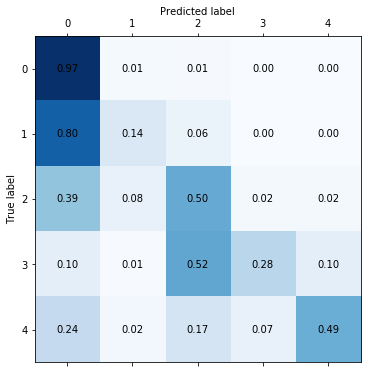

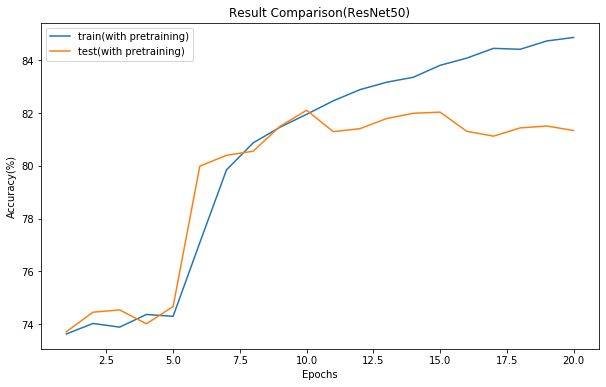

In [10]:
"""
resnet50 without pretrained weights
"""
'''
model_wo=ResNet50(num_class=num_class,pretrained=False)
optimizer=optim.SGD(model_wo.parameters(),lr=lr,momentum=momentum,weight_decay=weight_decay)
df_wo_pretrained=train(model_wo,loader_train,loader_test,Loss,optimizer,epochs,device,num_class,'resnet50_wo_pretraining')
# test and save confusion matrix figure
confusion_matrix,_=evaluate(model_wo,loader_test,device,num_class)
figure=plot_confusion_matrix(confusion_matrix)
figure.savefig('ResNet50 (wo pretrained weights).png')
'''
"""
resnet50 with pretrained weights
    first feature extraction for few epochs, then finefuning for some epochs
"""
model_with=ResNet50(num_class=num_class,pretrained=True)
# feature extraction
params_to_update=[]
for name,param in model_with.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)
optimizer=optim.SGD(params_to_update,lr=lr,momentum=momentum,weight_decay=weight_decay_feature_extraction)
df_firststep=train(model_with,loader_train,loader_test,Loss,optimizer,epochs_feature_extraction,device,num_class,'resnet50_with_pretraining')
# finetuning
for param in model_with.parameters():
    param.requires_grad=True
optimizer=optim.SGD(model_with.parameters(),lr=lr,momentum=momentum,weight_decay=weight_decay_finetuning)
df_secondstep=train(model_with,loader_train,loader_test,Loss,optimizer,epochs_fine_tuning,device,num_class,'resnet50_with_pretraining')
df_with_pretrained=pd.concat([df_firststep,df_secondstep],axis=0,ignore_index=True)

# test and get a confusion matrix
confusion_matrix,_=evaluate(model_with,loader_test,device,num_class)
figure=plot_confusion_matrix(confusion_matrix)
figure.savefig('ResNet50 (with pretrained weights).png')

"""
plot accuracy figure
"""
figure=plot(df_with_pretrained,'Result Comparison(ResNet50)')
figure.savefig('Result Comparison(ResNet50).png')

In [11]:
print(df_with_pretrained)

    epoch  acc_train   acc_test
0       1  73.621837  73.708185
1       2  74.020428  74.448399
2       3  73.881633  74.533808
3       4  74.362077  74.007117
4       5  74.290900  74.661922
5       1  77.084594  79.985765
6       2  79.846258  80.398577
7       3  80.871205  80.555160
8       4  81.461974  81.494662
9       5  81.953094  82.106762
10      6  82.465568  81.295374
11      7  82.889071  81.409253
12      8  83.170220  81.793594
13      9  83.358838  81.992883
14     10  83.810812  82.035587
15     11  84.084843  81.309609
16     12  84.454963  81.124555
17     13  84.419374  81.437722
18     14  84.736112  81.508897
19     15  84.867789  81.338078
